In [ ]:
from tqdm import tqdm
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms as T
import random
import time

import os
import requests
import zipfile

#Downloading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
if not (os.path.isfile("faces.zip") or os.path.isdir("faces")):
    # A part of the total dataset
    url = "https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_100000-133332_5_imgs.zip"
    response = requests.get(url, stream=True)

    with open("/content/drive/MyDrive/faces.zip", "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

In [ ]:
# Check if the zip file was already extracted
if not os.path.isdir("faces"):
    with zipfile.ZipFile("/content/drive/MyDrive/faces.zip", "r") as zip_ref:
        zip_ref.extractall("faces")

Mounted at /content/drive


In [ ]:
print(f"Some folders: {os.listdir('faces')[:5]}, there are a total of {len(os.listdir('faces'))} folders.")

Some folders: ['101047', '122469', '119604', '101990', '129977'], there are a total of 33333 folders.


# Plotting Images

In [ ]:
def plot_folder(path):
    img_paths = os.listdir(path)

    fig, ax = plt.subplots(1, 5)
    for i, img_path in enumerate(img_paths):
        img = Image.open(path + img_path)
        ax[i].imshow(img)

        ax[i].set_xticks([])
        ax[i].set_yticks([])

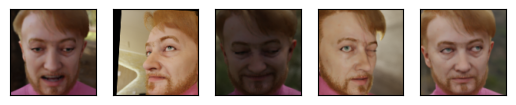

In [ ]:
plot_folder("/content/faces/101047/")

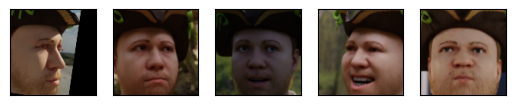

In [ ]:
plot_folder("/content/faces/122469/")

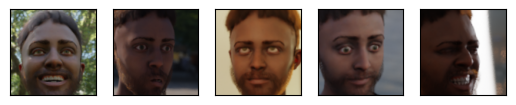

In [ ]:
plot_folder("/content/faces/119604/")

# Dataset

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, transform, identity_folders):
        # To later prevent data leakage between training and validation sets
        self.identity_folders = identity_folders
        self.transform = transform

    def __len__(self):
        return len(self.identity_folders)

    def get_image(self, path):
        img = Image.open(path)
        img = img.convert("RGB")
        return self.transform(img)

    def __getitem__(self, index):
        # The input index specifies the reference identity
        folder = self.identity_folders[index]
        img_paths = os.listdir(f"faces/{folder}/")

        # Anchor image is chosen from the folder
        anchor_index = random.randint(0, len(img_paths) - 1)
        anchor = self.get_image(f"faces/{folder}/{img_paths[anchor_index]}")

        # Positive image must be different from the anchor, but be the same identity
        positive_index = random.randint(0, len(img_paths) - 1)
        while positive_index == anchor_index:
            positive_index = random.randint(0, len(img_paths) - 1)
        positive = self.get_image(f"faces/{folder}/{img_paths[positive_index]}")

        # Negative image must be a different identity
        negative_folder = random.choice(self.identity_folders)
        while negative_folder == folder:
            negative_folder = random.choice(self.identity_folders)
        img_paths = os.listdir(f"faces/{negative_folder}")

        negative_index = random.randint(0, len(img_paths) - 1)
        negative = self.get_image(f"faces/{negative_folder}/{img_paths[negative_index]}")

        return anchor, positive, negative

In [ ]:
dataset = FaceDataset(T.ToTensor(), sorted(os.listdir("faces")))

In [ ]:
def plot_triplet(images):
    # Plot the images
    fig, ax = plt.subplots(1, 3)
    labels = ["Anchor", "Positive", "Negative"]
    for i, img in enumerate(images):
        # The shape of the image is changed to (3, 112, 112),
        # for plotting, we need the shape to be (112, 112, 3)
        ax[i].imshow(img.permute(1, 2, 0))

        # Hide the ticks
        ax[i].set_xticks([])
        ax[i].set_yticks([])

        # Add a label
        ax[i].set_title(labels[i])

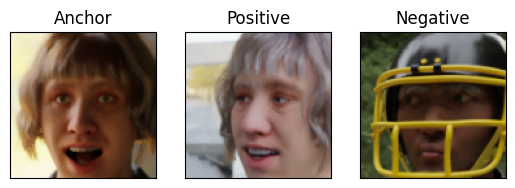

In [ ]:
plot_triplet(dataset[0])

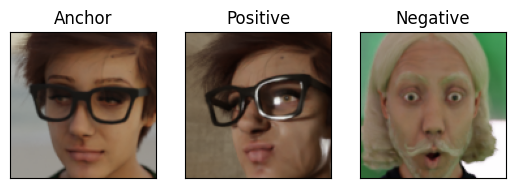

In [ ]:
plot_triplet(dataset[1])

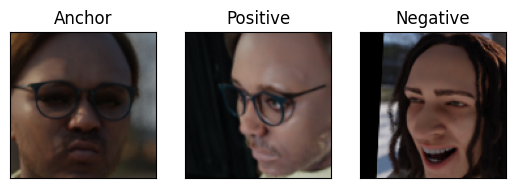

In [ ]:
plot_triplet(dataset[2])

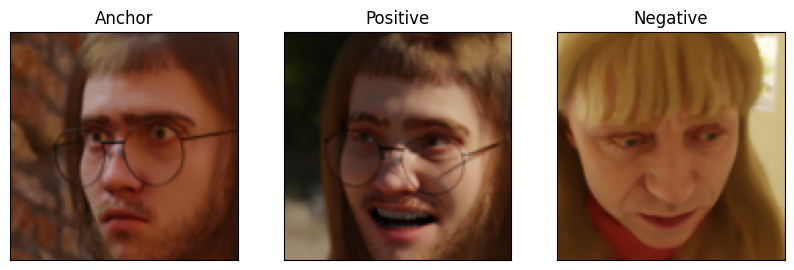

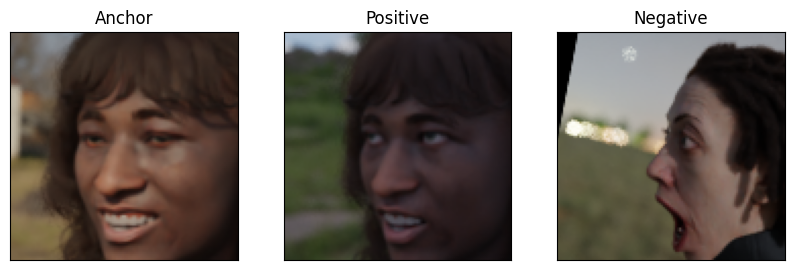

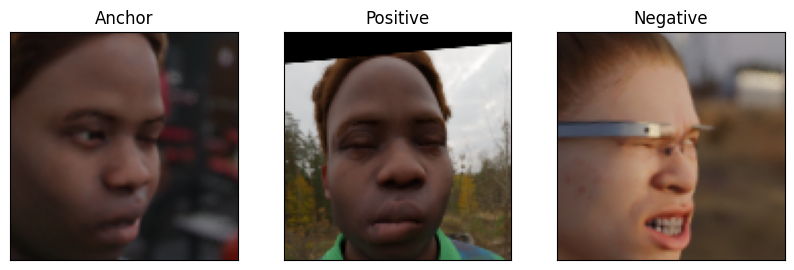

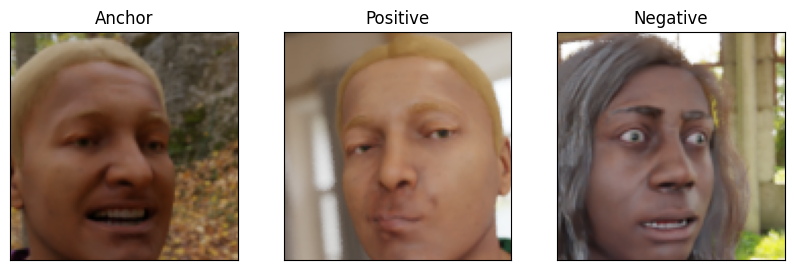

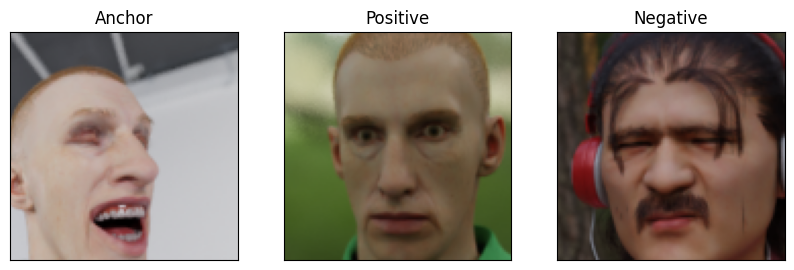

In [ ]:
import random
import matplotlib.pyplot as plt

# Function to plot a data point (triplet)
def plot_triplet_data_point(images):
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    labels = ["Anchor", "Positive", "Negative"]

    for i, img in enumerate(images):
        # Reshape the image tensor to (112, 112, 3) for plotting
        img_np = img.permute(1, 2, 0).numpy()
        ax[i].imshow(img_np)

        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(labels[i])

# Plot multiple triplets as data points
num_data_points = 5

for _ in range(num_data_points):
    # Get a random triplet from the dataset
    triplet = dataset[random.randint(0, len(dataset))]

    # Plot the triplet data point
    plot_triplet_data_point(triplet)
    plt.show()


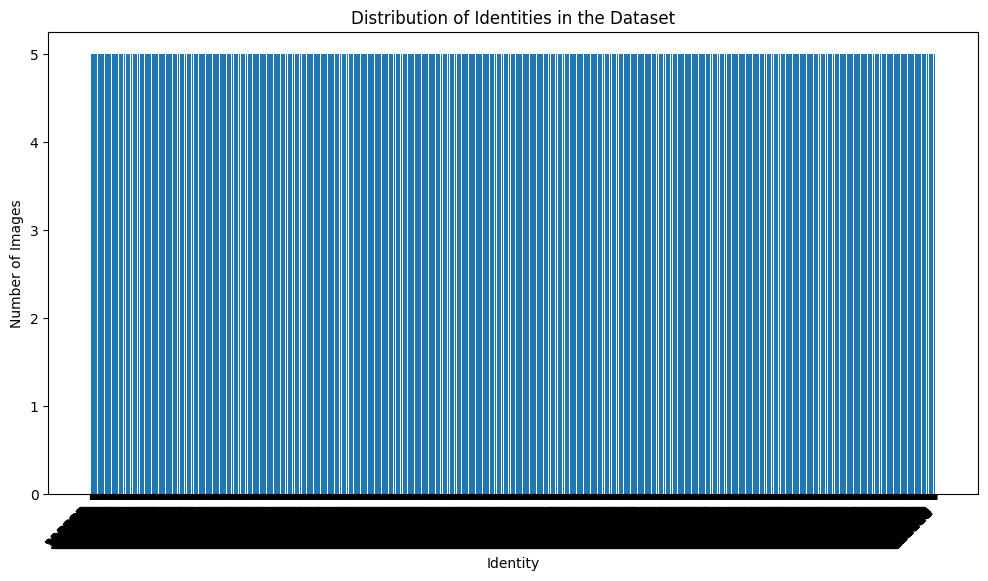

In [ ]:
# import matplotlib.pyplot as plt
# from collections import Counter

# # Count the occurrences of each identity in the dataset
# identity_counts = Counter(dataset.identity_folders)

# # Plot a bar graph
# plt.bar(identity_counts.keys(), identity_counts.values())
# plt.xlabel('Identity')
# plt.ylabel('Number of Images')
# plt.title('Distribution of Identities in the Dataset')
# plt.show()


import matplotlib.pyplot as plt

# Count the number of images per identity
identity_counts = {identity: len(os.listdir(f"faces/{identity}")) for identity in os.listdir("faces")}

# Plot a bar graph for the distribution of identities
plt.figure(figsize=(12, 6))
plt.bar(identity_counts.keys(), identity_counts.values())
plt.xlabel('Identity')
plt.ylabel('Number of Images')
plt.title('Distribution of Identities in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.show()



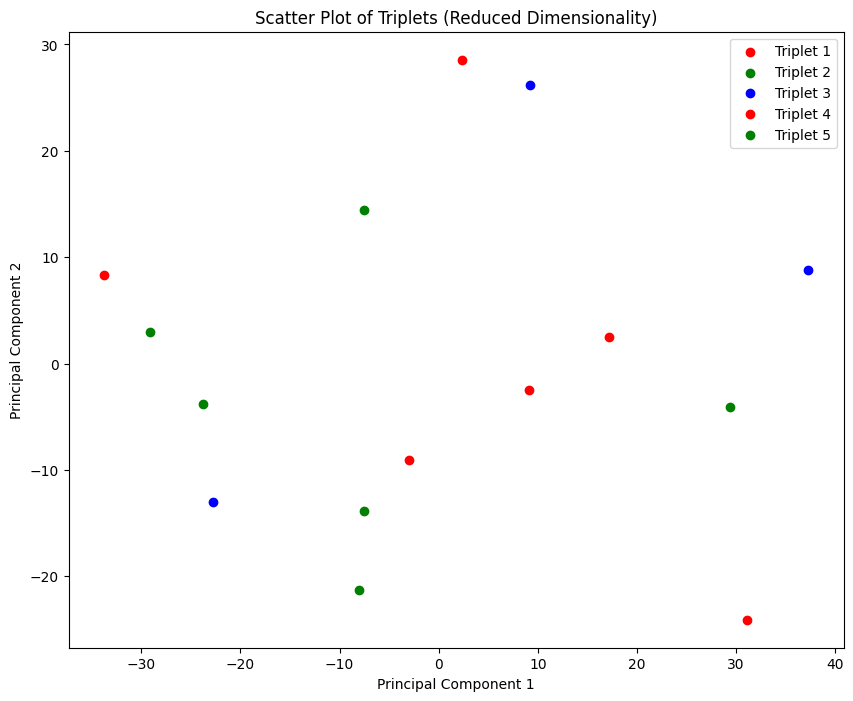

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Assuming the images have been converted to numpy arrays
def extract_features(images):
    return [img.flatten().numpy() for img in images]

# Extract features for a few triplets
num_triplets_to_plot = 5
features = []

for _ in range(num_triplets_to_plot):
    triplet = dataset[random.randint(0, len(dataset))]
    triplet_features = extract_features(triplet)
    features.extend(triplet_features)

features = np.array(features)

# Apply PCA to reduce dimensionality to 2 for scatter plot
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot scatter plot
plt.figure(figsize=(10, 8))
scatter_colors = ['r', 'g', 'b'] * (num_triplets_to_plot // 3 + 1)

for i in range(num_triplets_to_plot):
    start_idx = i * 3
    end_idx = (i + 1) * 3
    plt.scatter(reduced_features[start_idx:end_idx, 0], reduced_features[start_idx:end_idx, 1], label=f'Triplet {i + 1}', c=scatter_colors[i])

plt.title('Scatter Plot of Triplets (Reduced Dimensionality)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


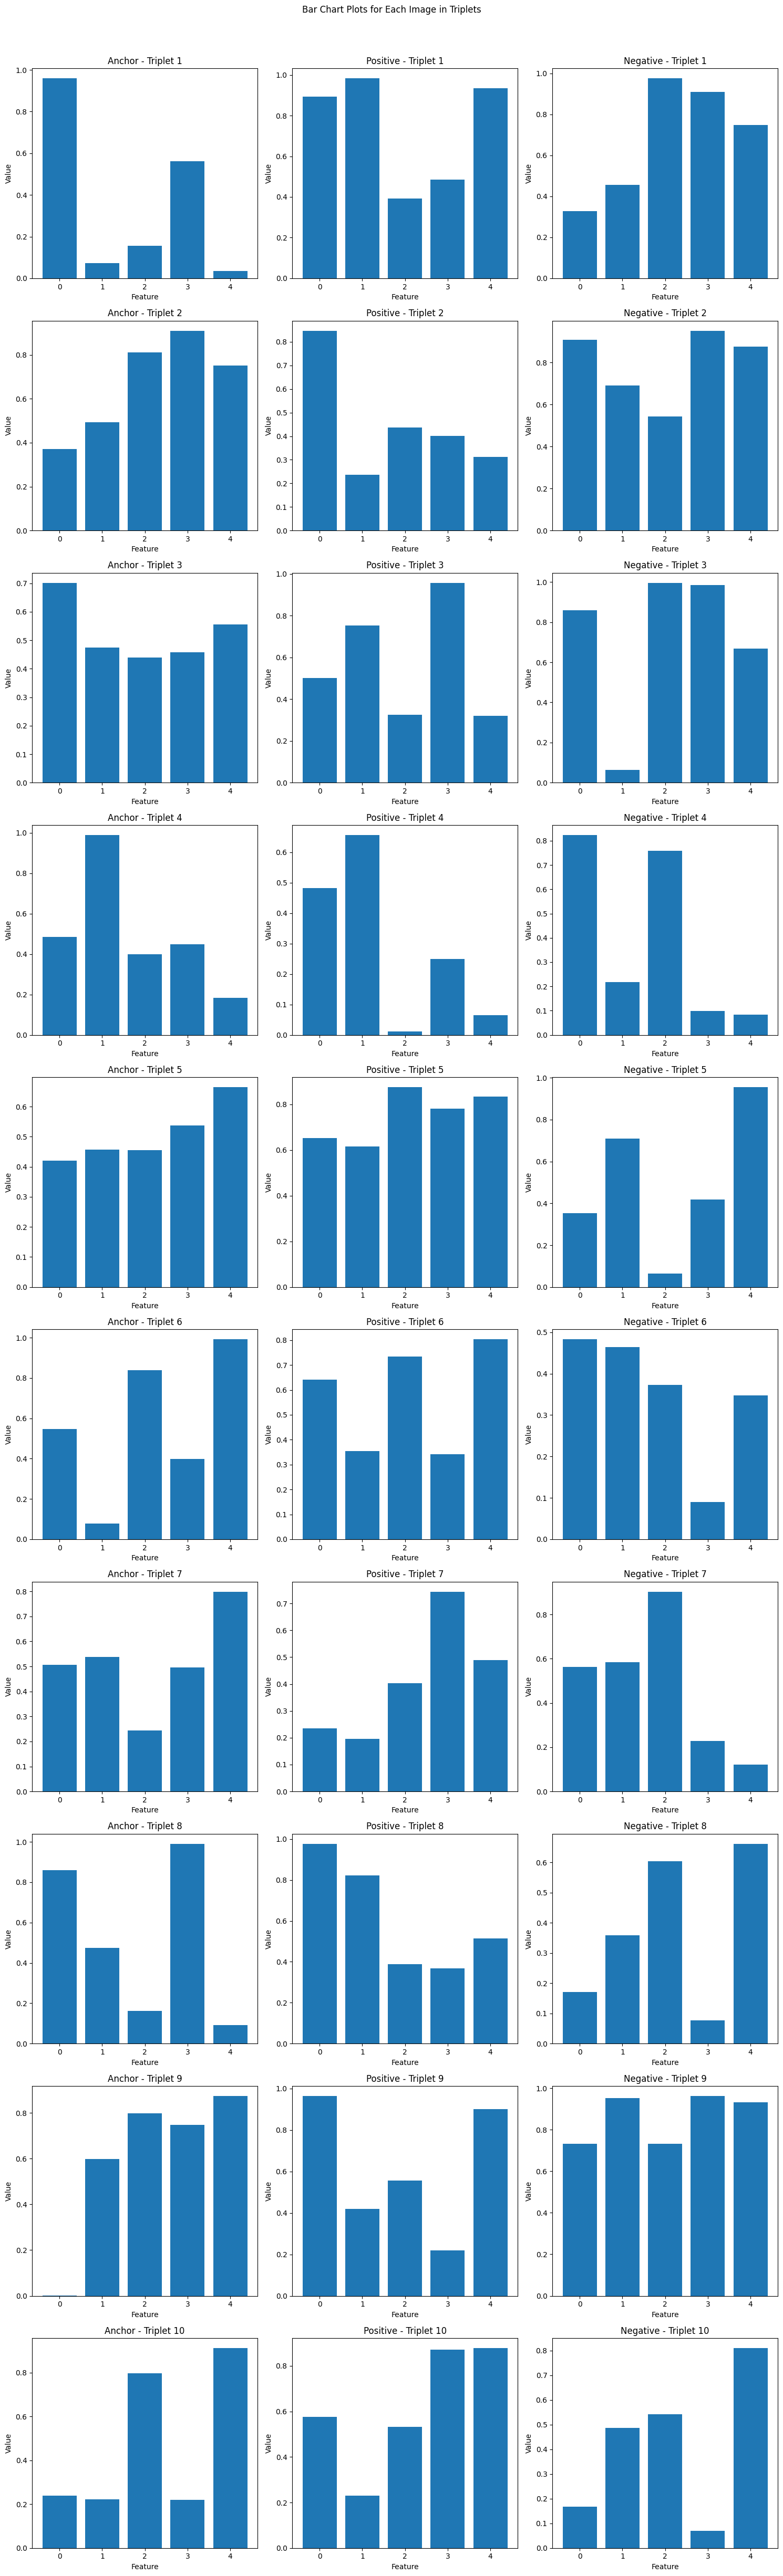

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Generating dummy data
num_triplets = 10
data_dimensions = 5

# Generate unique dummy data for each image in the triplets
dummy_data = np.random.rand(num_triplets, 3, data_dimensions)

# Plotting bar charts for each image in the triplets
fig, axs = plt.subplots(num_triplets, 3, figsize=(15, 5 * num_triplets))
fig.suptitle('Bar Chart Plots for Each Image in Triplets')

labels = ["Anchor", "Positive", "Negative"]

for i in range(num_triplets):
    for j in range(3):  # Anchor, Positive, Negative
        data = dummy_data[i, j]  # Use unique data for each image
        axs[i, j].bar(range(data_dimensions), data)
        axs[i, j].set_title(f'{labels[j]} - Triplet {i + 1}')
        axs[i, j].set_xlabel('Feature')
        axs[i, j].set_ylabel('Value')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


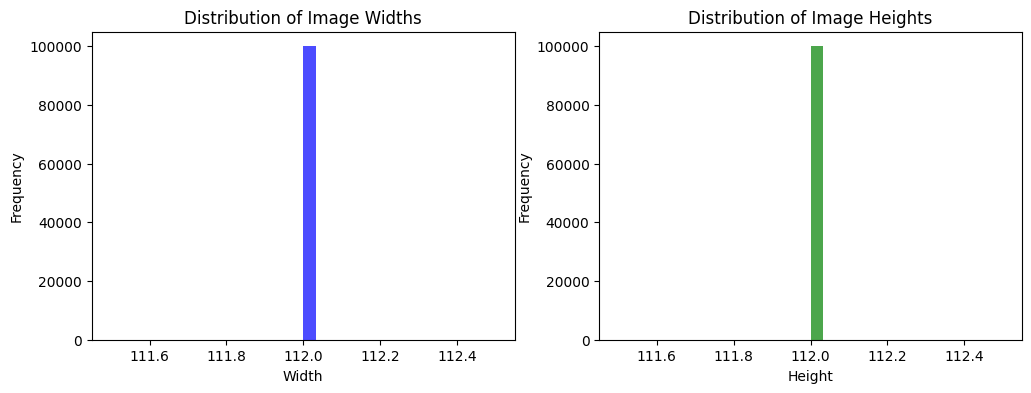

In [ ]:
# Collect image sizes
image_sizes = [(img.size()[1], img.size()[2]) for triplet in dataset for img in triplet]

# Plot histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist([size[0] for size in image_sizes], bins=30, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Image Widths')
axs[0].set_xlabel('Width')
axs[0].set_ylabel('Frequency')

axs[1].hist([size[1] for size in image_sizes], bins=30, color='green', alpha=0.7)
axs[1].set_title('Distribution of Image Heights')
axs[1].set_xlabel('Height')
axs[1].set_ylabel('Frequency')

plt.show()


# Model training

In [ ]:
!pip install torchinfo

In [ ]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import torchinfo

In [ ]:
backbone = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
torchinfo.summary(backbone, (1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 108MB/s]


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           3,440
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6   

In [ ]:
class Trainer:
    def __init__(self, model, device, optimizer, criterion):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = {
            "train_loss": [],
            "train_accuracy": [],
            "val_loss": [],
            "val_accuracy": [],
            "train_val_loss": [],
            "train_val_accuracy": [],
        }

    def _train(self, dataloader):
        self.model.train()
        total_loss, correct = 0, 0
        for batch, (a, p, n) in tqdm(enumerate(dataloader)):
            a, p, n = a.to(self.device), p.to(self.device), n.to(self.device)

            # Forward
            p_out, n_out = self.model.triplet_forward(a, p, n)

            # Loss
            loss1 = self.criterion(p_out, torch.ones_like(p_out))
            loss2 = self.criterion(n_out, torch.zeros_like(n_out))
            loss = loss1 + loss2

            # Metrics
            total_loss += loss
            correct += torch.sum(p_out >= 0.5) / p_out.shape[0]
            correct += torch.sum(n_out < 0.5) / n_out.shape[0]

            # Step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        total_loss /= len(dataloader)
        correct = correct / (2 * len(dataloader)) # Each triplet is checked twice

        return total_loss, correct


    def _val(self, dataloader):
        self.model.eval()
        total_loss, correct = 0, 0
        for batch, (a, p, n) in enumerate(dataloader):
            a, p, n = a.to(self.device), p.to(self.device), n.to(self.device)

            # Forward
            with torch.inference_mode():
                p_out, n_out = self.model.triplet_forward(a, p, n)

            # Loss
            loss1 = self.criterion(p_out, torch.ones_like(p_out))
            loss2 = self.criterion(n_out, torch.zeros_like(n_out))
            loss = loss1 + loss2

            # Metrics
            total_loss += loss
            correct += torch.sum(p_out >= 0.5) / p_out.shape[0]
            correct += torch.sum(n_out < 0.5) / n_out.shape[0]


        total_loss /= len(dataloader)
        correct = correct / (2 * len(dataloader)) # Each triplet is checked twice

        return total_loss, correct

    def fit(self, epochs, save_every, train_loader, val_loader, train_val_loader=None, scheduler=None):
        """Fits the model to the given data and plots the results over epochs.

        Args:
            epochs (int): Number of epochs to train the model for.
            train_loader (DataLoader): Dataloader used for training.
            val_loader (DataLoader): Dataloader used for validation.
            save_every (int): The number of epochs to save a checkpoint after.
            train_val_loader (DataLoader): Dataloader used for data mismatch insights.
            scheduler (lr_scheduler): The learning rate scheduler.
        """
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}\n---------")
            self.train_for_one_epoch(train_loader, "train")

            if train_val_loader:
                self.validate_for_one_epoch(train_val_loader, "train_val")

            self.validate_for_one_epoch(val_loader, "val")

            self.save_checkpoint(epoch, save_every)

            if scheduler:
                scheduler.step()

        self.plot_metrics(train_val_loader is not None)

    def train_for_one_epoch(self, data_loader, prefix):
        loss, accuracy = self._train(data_loader)
        self.log_metrics(loss, accuracy, prefix)

    def validate_for_one_epoch(self, data_loader, prefix):
        loss, accuracy = self._val(data_loader)
        self.log_metrics(loss, accuracy, prefix)

    def log_metrics(self, loss, accuracy, prefix):
        print(f"{prefix.capitalize()}: {loss:.4f} loss, {accuracy * 100:.2f}% correct")
        self.metrics[f"{prefix}_loss"].append(loss.cpu().detach())
        self.metrics[f"{prefix}_accuracy"].append(accuracy.cpu().detach())

    def save_checkpoint(self, epoch, save_every):
        if epoch % save_every == save_every - 1:
            torch.save(self.model.state_dict(), "checkpoint.pt")

    def plot_metrics(self, has_train_val):
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        epochs = range(len(self.metrics["train_loss"]))
        self.configure_plot(ax[0], epochs, "Loss", ["train_loss", "val_loss"], ["Training", "Validation"])
        self.configure_plot(ax[1], epochs, "Accuracy", ["train_accuracy", "val_accuracy"], ["Training", "Validation"])

        if has_train_val:
            self.configure_plot(ax[0], epochs, "Loss", ["train_val_loss"], ["Train-Val"])
            self.configure_plot(ax[1], epochs, "Accuracy", ["train_val_accuracy"], ["Train-Val"])
        plt.show()

    def configure_plot(self, ax, epochs, title, metric_keys, labels):
        for key, label in zip(metric_keys, labels):
            ax.plot(epochs, self.metrics[key], label=label)
        if title == "Loss":
            ax.legend(loc="upper right")
        else:
            ax.legend(loc="lower right")
        ax.set_title(title)

In [ ]:
class SiameseModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        # Load backbone ResNet
        backbone = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        backbone.requires_grad_(False) # Freeze backbone weights

        # Replace the classifier part
        backbone.classifier = nn.Sequential(
            nn.Linear(in_features=960, out_features=256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(in_features=256, out_features=256)
        )

        self.feature_extractor = backbone

        self.logistic = nn.Linear(in_features=256, out_features=1)


    def forward(self, x):
        return self.model.forward(x)

    def predict(self, x1, x2):
        output = self.forward(x1, x2)
        return torch.sigmoid(output) >= 0.5

    def predict_from_output(self, output):
        return torch.sigmoid(output) >= 0.5

    def triplet_forward(self, a, p, n):
        a_out = self.feature_extractor(a)
        p_out = self.feature_extractor(p)
        n_out = self.feature_extractor(n)

        p_out = self.logistic(torch.abs(a_out - p_out))
        n_out = self.logistic(torch.abs(a_out - n_out))
        return p_out, n_out

    def forward(self, x1, x2):
        x1 = self.feature_extractor(x1)
        x2 = self.feature_extractor(x2)
        return self.logistic(torch.abs(x1 - x2))

In [ ]:
torch.manual_seed(42)
train_folders, train_val_folders, val_folders = torch.utils.data.random_split(
    sorted(os.listdir("faces")), [0.8, 0.1, 0.1]
)

augment = T.Compose([
    # The magnitude bins determine the strength of augmentation (max 31)
    T.TrivialAugmentWide(num_magnitude_bins=31),
    T.ToTensor(),
])

train_set = FaceDataset(augment, train_folders)
train_val_set = FaceDataset(augment, train_val_folders)
val_set = FaceDataset(T.ToTensor(), val_folders)

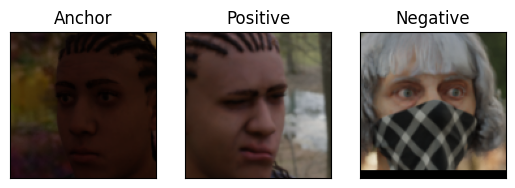

In [ ]:
plot_triplet(train_set[0])

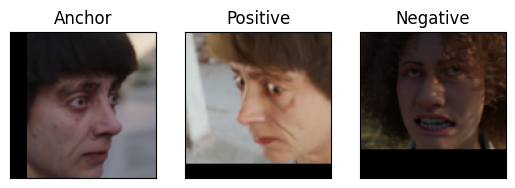

In [ ]:
plot_triplet(train_val_set[0])

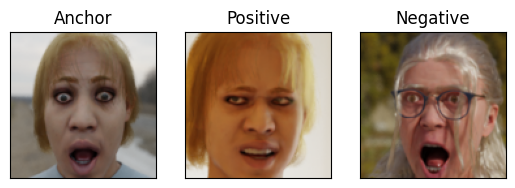

In [ ]:
plot_triplet(val_set[0])

In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, num_workers=1)
train_val_loader = DataLoader(train_val_set, batch_size=64, pin_memory=True, num_workers=1)
val_loader = DataLoader(val_set, batch_size=64, pin_memory=True, num_workers=1)

In [ ]:
torch.manual_seed(42)
model_v1 = SiameseModelV1().to('cuda')
# Show the model in detail
torchinfo.summary(model_v1, ((1, 3, 112, 112), (1, 3, 112, 112)))

Layer (type:depth-idx)                                  Output Shape              Param #
SiameseModelV1                                          [1, 1]                    --
├─MobileNetV3: 1-1                                      [1, 256]                  --
│    └─Sequential: 2-1                                  [1, 960, 4, 4]            --
│    │    └─Conv2dNormActivation: 3-1                   [1, 16, 56, 56]           (464)
│    │    └─InvertedResidual: 3-2                       [1, 16, 56, 56]           (464)
│    │    └─InvertedResidual: 3-3                       [1, 24, 28, 28]           (3,440)
│    │    └─InvertedResidual: 3-4                       [1, 24, 28, 28]           (4,440)
│    │    └─InvertedResidual: 3-5                       [1, 40, 14, 14]           (10,328)
│    │    └─InvertedResidual: 3-6                       [1, 40, 14, 14]           (20,992)
│    │    └─InvertedResidual: 3-7                       [1, 40, 14, 14]           (20,992)
│    │    └─InvertedResidu

In [ ]:
torch.manual_seed(42)
optimizer = torch.optim.SGD(model_v1.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()
trainer = Trainer(model_v1, 'cuda', optimizer, criterion)

Epoch 1
---------


417it [03:51,  1.80it/s]

Train: 1.2348 loss, 57.65% correct


Train_val: 1.0630 loss, 68.58% correct
Val: 0.9704 loss, 72.34% correct
Epoch 2
---------


417it [03:05,  2.25it/s]

Train: 1.0111 loss, 72.15% correct


Train_val: 0.9609 loss, 72.95% correct
Val: 0.8367 loss, 76.62% correct
Epoch 3
---------


417it [03:02,  2.28it/s]

Train: 0.9330 loss, 75.78% correct


Train_val: 0.9278 loss, 76.29% correct
Val: 0.7763 loss, 81.45% correct
Epoch 4
---------


417it [03:09,  2.20it/s]

Train: 0.8872 loss, 77.35% correct


Train_val: 0.8810 loss, 78.15% correct
Val: 0.7188 loss, 83.37% correct
Epoch 5
---------


417it [03:04,  2.26it/s]

Train: 0.8621 loss, 78.52% correct


Train_val: 0.8540 loss, 78.38% correct
Val: 0.6985 loss, 83.71% correct
Epoch 6
---------


417it [03:08,  2.21it/s]

Train: 0.8442 loss, 79.18% correct


Train_val: 0.8380 loss, 78.84% correct
Val: 0.6733 loss, 83.97% correct
Epoch 7
---------


417it [03:03,  2.27it/s]

Train: 0.8350 loss, 79.45% correct


Train_val: 0.8005 loss, 79.96% correct
Val: 0.6601 loss, 84.58% correct
Epoch 8
---------


417it [03:01,  2.30it/s]

Train: 0.8206 loss, 79.74% correct


Train_val: 0.8273 loss, 77.64% correct
Val: 0.6589 loss, 83.73% correct
Epoch 9
---------


417it [03:00,  2.30it/s]

Train: 0.8040 loss, 80.25% correct


Train_val: 0.7937 loss, 79.44% correct
Val: 0.6428 loss, 84.68% correct
Epoch 10
---------


417it [02:59,  2.33it/s]

Train: 0.7913 loss, 80.77% correct


Train_val: 0.7947 loss, 79.50% correct
Val: 0.5992 loss, 85.48% correct


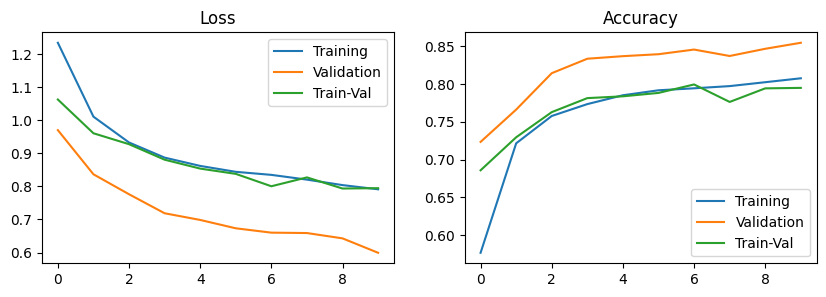

In [ ]:
starts = time.time()
trainer.fit(
    epochs=10,
    save_every=5,
    train_loader=train_loader,
    val_loader=val_loader,
    train_val_loader=train_val_loader,
)
ends = time.time()

In [ ]:
print("Time taken to train the model: ", ends-starts)

Time taken to train the model:  2290.299240589142


# Parallelization

In [ ]:
from torch.nn.parallel import DataParallel

Epoch 1
---------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
417it [02:21,  2.95it/s]

Train: 1.2333 loss, 57.43% correct


Train_val: 1.0825 loss, 69.88% correct
Val: 0.9778 loss, 73.89% correct
Epoch 2
---------


417it [02:19,  3.00it/s]

Train: 1.0094 loss, 72.33% correct


Train_val: 0.9457 loss, 75.67% correct
Val: 0.8139 loss, 80.16% correct
Epoch 3
---------


417it [02:19,  2.98it/s]

Train: 0.9298 loss, 75.88% correct


Train_val: 0.9154 loss, 75.83% correct
Val: 0.7586 loss, 81.52% correct
Epoch 4
---------


417it [02:20,  2.97it/s]

Train: 0.8954 loss, 77.07% correct


Train_val: 0.9016 loss, 75.32% correct
Val: 0.7248 loss, 81.15% correct
Epoch 5
---------


417it [02:19,  2.98it/s]

Train: 0.8692 loss, 78.03% correct


Train_val: 0.8618 loss, 78.30% correct
Val: 0.6857 loss, 83.64% correct
Epoch 6
---------


417it [02:21,  2.95it/s]

Train: 0.8467 loss, 78.90% correct


Train_val: 0.8611 loss, 77.95% correct
Val: 0.6702 loss, 83.43% correct
Epoch 7
---------


417it [02:21,  2.94it/s]

Train: 0.8330 loss, 79.51% correct


Train_val: 0.8889 loss, 77.43% correct
Val: 0.6262 loss, 85.68% correct
Epoch 8
---------


417it [02:19,  2.99it/s]

Train: 0.8156 loss, 80.13% correct


Train_val: 0.8051 loss, 81.30% correct
Val: 0.6500 loss, 86.01% correct
Epoch 9
---------


417it [02:25,  2.87it/s]

Train: 0.8105 loss, 80.13% correct


Train_val: 0.8269 loss, 79.41% correct
Val: 0.6543 loss, 84.14% correct
Epoch 10
---------


417it [02:23,  2.90it/s]

Train: 0.7966 loss, 80.42% correct


Train_val: 0.8019 loss, 81.11% correct
Val: 0.6116 loss, 87.01% correct


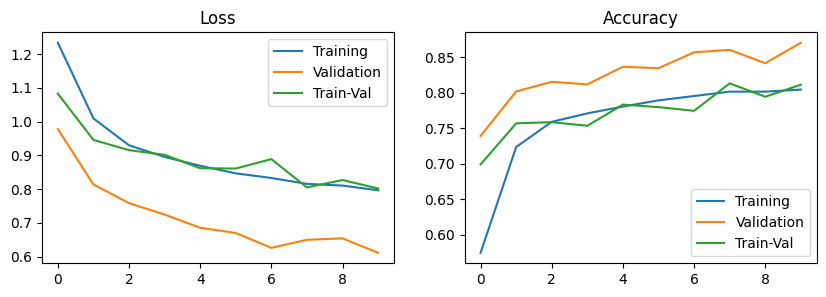

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

model = SiameseModelV1()
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()
trainer = Trainer(model, device, optimizer, criterion)

startp = time.time()
trainer.fit(
    epochs=10,
    save_every=5,
    train_loader=train_loader,
    val_loader=val_loader,
    train_val_loader=train_val_loader,
)
endp = time.time()

In [ ]:
print("Time taken: ", endp - startp)

Time taken:  1845.6194655895233


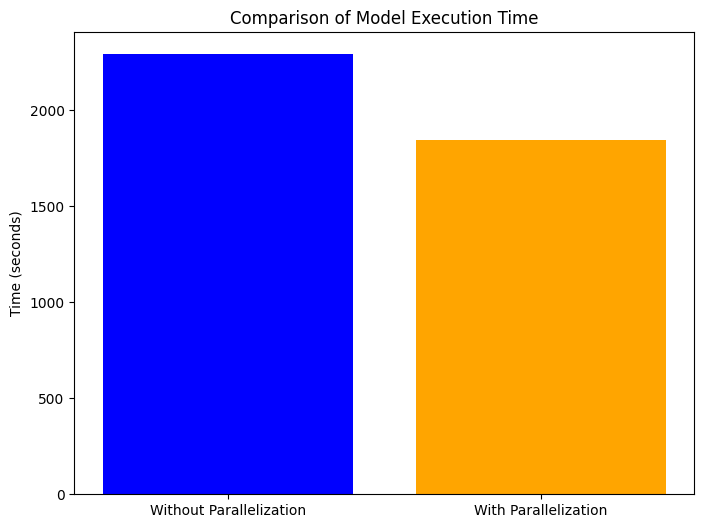

In [ ]:
import matplotlib.pyplot as plt

# Time taken without parallelization
time_without_parallelization = ends-starts

# Time taken with parallelization
time_with_parallelization = endp - startp

# Data for the bar chart
labels = ['Without Parallelization', 'With Parallelization']
times = [time_without_parallelization, time_with_parallelization]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, times, color=['blue', 'orange'])
plt.ylabel('Time (seconds)')
plt.title('Comparison of Model Execution Time')
plt.show()
